## Introducción a Feature Descriptors y HOG

### ¿Qué es un Feature Descriptor? (El Concepto)

- Es una transformación que simplifica una imagen.
- Entrada: Tu imagen original (ej. 64×128 píxeles con 3 canales de color).
- Salida: Un "vector de características" (una lista larga de números, ej. 3780 números).
- Objetivo: Quedarse solo con la información útil para que una computadora pueda procesarla y eliminar la información "sobrante" (extraneous).

### ¿Para qué sirve? (La Utilidad)

- Ese vector numérico no sirve para que tú veas la imagen, sirve para algoritmos de clasificación (como SVM).
- Al convertir la imagen en este vector, facilitas que la IA detecte patrones y diferencie objetos (ej. distinguir un botón de una moneda).

### ¿Qué considera HOG como "Útil"? (El Método)

- Para HOG, lo útil es la forma y los bordes, no el color plano.
- La Lógica: Los bordes y esquinas (donde la intensidad de la luz cambia bruscamente) definen la forma de un objeto.
- La Técnica: HOG calcula gradientes (cambios de intensidad) y sus direcciones.
- Ejemplo del texto: Si quieres detectar un botón, el color no importa tanto como su borde circular y los agujeros del centro. HOG captura esa estructura de bordes.

## Paso 1: Preprocesamiento

- Siguiendo la lógica anterior, antes de extraer esas "características útiles" (bordes, formas), necesitamos preparar la imagen para que el algoritmo la entienda. Aquí lo más relevante es la estandarización.

1. El requisito de tamaño (64×128)

- El algoritmo HOG original (diseñado para detectar personas de pie) es muy estricto: necesita que la "ventanita" de imagen que analiza mida exactamente 64 píxeles de ancho por 128 de alto.
  - ¿Por qué? Porque el cálculo matemático posterior (el vector de características de longitud 3780) depende de que la entrada tenga siempre ese tamaño fijo.

2. La proporción "Sagrada" (1:2)

- Como el destino final debe ser 64×128, cualquier recorte que hagas en tu imagen original debe respetar una proporción de aspecto de 1:2 (el alto debe ser el doble que el ancho).
  - Sí puedes hacer: Recortar un trozo de 100×200 píxeles o 500×1000.
  - No debes hacer: Recortar 101×205, porque al reducirlo a 64×128 la imagen se deformaría y los patrones cambiarían.

3. El flujo de trabajo

- La imagen lo resume perfectamente en tres pasos:
  - Tienes tu imagen original de cualquier tamaño (ej. 720×475).
  - Haces un recorte (Crop) donde crees que está el objeto, respetando la proporción 1:2 (ej. recortas al corredor en un cuadro de 100×200).
  - Redimensionas (Resize) ese recorte para encajarlo a la fuerza en el molde de 64×128.

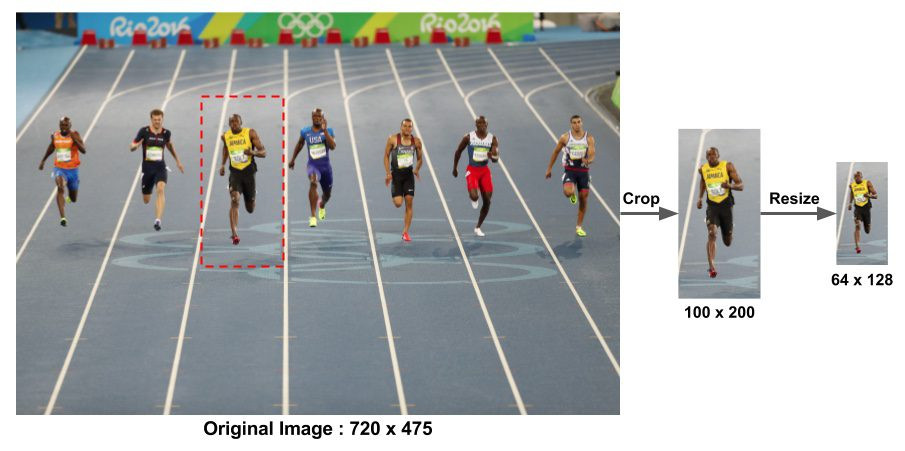

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

%matplotlib inline

In [ ]:
# Variables globales para el dibujo
drawing = False
start_point = None
end_point = None
temp_image = None

def draw_rectangle(event, x, y, flags, param):
    """Callback para dibujar el rectángulo de selección"""
    global drawing, start_point, end_point, temp_image
    
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        start_point = (x, y)
        end_point = (x, y)
    
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            end_point = (x, y)
            # Crear copia temporal para mostrar el rectángulo
            temp_image = param['original'].copy()
            
            # Calcular dimensiones manteniendo proporción 1:2
            width = abs(end_point[0] - start_point[0])
            height = abs(end_point[1] - start_point[1])
            
            # Ajustar altura para mantener proporción 1:2 (altura = 2 * ancho)
            if width > 0:
                height_adjusted = width * 2
                if end_point[1] > start_point[1]:
                    end_point = (end_point[0], start_point[1] + height_adjusted)
                else:
                    end_point = (end_point[0], start_point[1] - height_adjusted)
            
            cv2.rectangle(temp_image, start_point, end_point, (0, 255, 0), 2)
            
            # Mostrar dimensiones
            text = f"Proporcion 1:2 - {abs(end_point[0]-start_point[0])}x{abs(end_point[1]-start_point[1])}"
            cv2.putText(temp_image, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                       0.7, (0, 255, 0), 2)
            
            cv2.imshow('Seleccionar Region (1:2)', temp_image)
    
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        end_point = (x, y)
        
        # Ajustar para mantener proporción 1:2
        width = abs(end_point[0] - start_point[0])
        height_adjusted = width * 2
        if end_point[1] > start_point[1]:
            end_point = (end_point[0], start_point[1] + height_adjusted)
        else:
            end_point = (end_point[0], start_point[1] - height_adjusted)

# Cargar la imagen
image_path = 'carrera.png'
img = cv2.imread(image_path)

if img is None:
    print(f"Error: No se pudo cargar la imagen '{image_path}'")
    print("Asegúrate de que la imagen existe en la ruta especificada")
else:
    # Crear una copia para mostrar
    display_img = img.copy()
    temp_image = img.copy()
    
    # Crear ventana y configurar callback
    cv2.namedWindow('Seleccionar Region (1:2)')
    cv2.setMouseCallback('Seleccionar Region (1:2)', draw_rectangle, {'original': img})
    
    print("INSTRUCCIONES ")
    print("1. Dibuja un rectángulo alrededor de Usain Bolt")
    print("2. El rectángulo se ajustará automáticamente a proporción 1:2 (ancho:alto)")
    print("3. Presiona 'ENTER' para confirmar la selección")
    print("4. Presiona 'R' para reiniciar la selección")
    print("5. Presiona 'ESC' para salir")
    print("\n")
    
    cv2.imshow('Seleccionar Region (1:2)', display_img)
    
    while True:
        key = cv2.waitKey(1) & 0xFF
        
        # ESC para salir
        if key == 27:
            print("Operación cancelada")
            break
        
        # R para reiniciar
        elif key == ord('r') or key == ord('R'):
            start_point = None
            end_point = None
            display_img = img.copy()
            temp_image = img.copy()
            cv2.imshow('Seleccionar Region (1:2)', display_img)
            print("Selección reiniciada")
        
        # ENTER para confirmar
        elif key == 13:  # Enter
            if start_point and end_point:
                # Calcular coordenadas del recorte
                x1 = min(start_point[0], end_point[0])
                y1 = min(start_point[1], end_point[1])
                x2 = max(start_point[0], end_point[0])
                y2 = max(start_point[1], end_point[1])
                
                # Asegurar que no salgan de los límites
                x1 = max(0, x1)
                y1 = max(0, y1)
                x2 = min(img.shape[1], x2)
                y2 = min(img.shape[0], y2)
                
                # Recortar la región
                cropped = img[y1:y2, x1:x2]
                
                if cropped.size > 0:
                    # Redimensionar a 64x128 (tamaño estándar para HOG)
                    resized = cv2.resize(cropped, (64, 128), interpolation=cv2.INTER_LINEAR)
                    
                    print(f"\nImagen original: {img.shape[1]}x{img.shape[0]}")
                    print(f"Región seleccionada (1:2): {x2-x1}x{y2-y1}")
                    print(f"Imagen redimensionada (HOG): {resized.shape[1]}x{resized.shape[0]}")
                    
                    # Mostrar resultados
                    cv2.imshow('1. Original', img)
                    cv2.imshow('2. Recorte (proporcion 1:2)', cropped)
                    cv2.imshow('3. Redimensionado 64x128 (HOG)', resized)
                    
                    print("\nPresiona cualquier tecla para cerrar las ventanas...")
                    cv2.waitKey(0)
                    
                    # Guardar la imagen procesada
                    cv2.imwrite('usain_bolt_hog_64x128.jpg', resized)
                    print(f"Imagen guardada como 'usain_bolt_hog_64x128.jpg'")
                else:
                    print("Error: La región seleccionada es inválida")
                
                break
            else:
                print("Primero debes seleccionar una región")
    
    cv2.destroyAllWindows()

### Paso 2: Calcular el Gradiente

- Aquí es donde dejamos de ver la imagen como "colores" y empezamos a verla como "cambios matemáticos".

1. El Objetivo (¿Qué buscamos?)

- Queremos deshacernos de la información inútil (como un fondo de color plano) y resaltar solo los contornos y siluetas.

2. La Herramienta: Derivadas (Sobel)

- Para encontrar estos contornos, calculamos derivadas (cambios de intensidad). Lo hacemos en dos direcciones separadas:
  - Gradiente en X (gx​): Detecta líneas verticales. Dispara cuando hay un cambio de intensidad de izquierda a derecha.
  - Gradiente en Y (gy​): Detecta líneas horizontales. Dispara cuando hay un cambio de arriba a abajo.
- La Matemática simple: El algoritmo pasa un filtro pequeño (kernel) de 1×3: [−1,0,1]. Básicamente, para cada píxel, resta el valor del vecino de la izquierda del vecino de la derecha. Si son iguales (zona plana), el resultado es 0 (negro). Si son diferentes (borde), el resultado es un número alto (brillante).

3. El Resultado Final: Magnitud y Ángulo

- Una vez que tienes gx​ y gy​, combinas esa información para obtener dos valores críticos por cada píxel:
  - Magnitud (g): ¿Qué tan fuerte es el borde?
    - g=gx2​+gy2​​
  - Dirección/Ángulo (θ): ¿Hacia dónde apunta el borde?
    - θ=arctan(gx​gy​​)
- En código (OpenCV), esto se simplifica enormemente usando cv2.cartToPolar, que te devuelve ambos valores de golpe.

4. Un detalle clave sobre el color

- Como tu imagen tiene 3 canales (Rojo, Verde, Azul), el gradiente se calcula para los tres. ¿Con cuál nos quedamos?
  - HOG elige el máximo gradiente de los tres canales para cada píxel.
  - Ejemplo: Si en un píxel el canal rojo es plano pero el azul tiene un borde muy marcado, HOG usa el valor del azul.

Resumen del Paso 2: Convertimos la foto del corredor en una "mapa de flechas" donde cada píxel nos dice: "Aquí hay un borde, es así de fuerte (magnitud) y apunta hacia allá (dirección)".

In [2]:
# Calcular gradientes usando la imagen redimensionada

im = cv2.imread('usain_bolt_hog_64x128.jpg')
im = np.float32(im) / 255.0

# Calculate gradient
gx = cv2.Sobel(im, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(im, cv2.CV_32F, 0, 1, ksize=1)

In [3]:
# Python Calculate gradient magnitude and direction ( in degrees )
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

In [ ]:
print("Presiona cualquier tecla para cerrar")

cv2.imshow('Magnitud del Gradiente', mag / np.max(mag))
cv2.imshow('Angulo del Gradiente', angle / 360.0)

cv2.waitKey(0)
cv2.destroyAllWindows()

print("Ventanas cerradas")

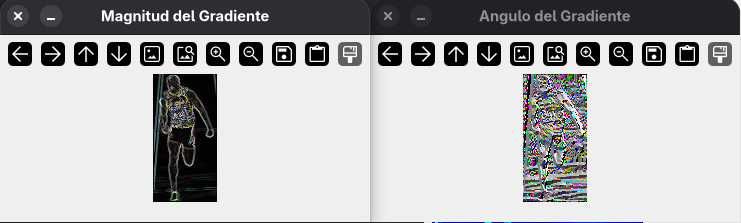

### Paso 3: Calcular el histograma de gradientes en celdas 8x8

1. El Concepto: "Divide y Vencerás" (Resumen vs. Ruido)

- Hasta ahora teníamos un mapa de píxeles donde cada uno tenía una flecha (gradiente). Eso es demasiada información y mucho ruido.
  - La solución: Dividimos la imagen en pequeñas celdas cuadradas de 8×8 píxeles.
  - El objetivo: En lugar de mirar 64 flechas individuales dentro de esa celda, queremos un solo gráfico (histograma) que nos diga: "En esta pequeña zona, la tendencia general de las líneas es vertical/horizontal/diagonal".
  - Resultado: Pasamos de tener 8×8×3 (192 valores de color) a solo 9 números que resumen esa celda. Mucho más compacto y robusto al ruido.
- 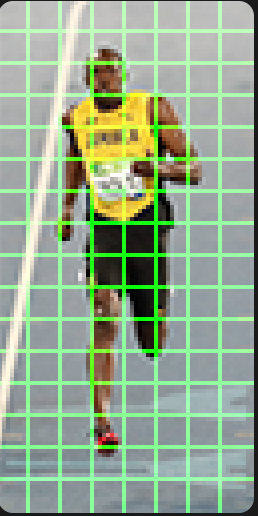

2. El Histograma: Las 9 Cubetas (Bins)

- Para resumir la celda, creamos un histograma con 9 cubetas (bins).
  - Cada cubeta representa un ángulo: 0∘,20∘,40∘,…,160∘.
  - Nota importante ("Unsigned Gradients"): Usamos ángulos de 0 a 180 grados, no hasta 360.
  - ¿Por qué? Porque para detectar formas (como una pierna), nos da igual si el borde va de negro a blanco o de blanco a negro. Una línea vertical es una línea vertical, sin importar el sentido.
- 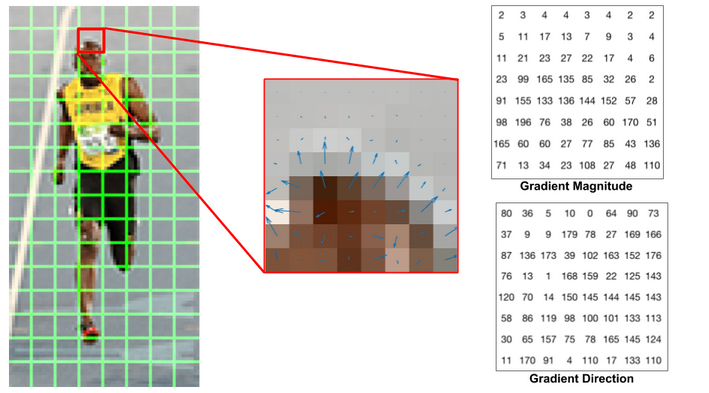

3. El Sistema de Votación (Cómo se llena el histograma)

- Cada uno de los 64 píxeles dentro de la celda emite un "voto" para decidir qué orientación domina. Pero es una votación inteligente:
  - El peso del voto (Magnitud): No es "un hombre, un voto". Es "más fuerza, más voto". Si un píxel tiene un gradiente muy fuerte (un borde muy marcado), su voto cuenta más en el histograma. Si es una zona casi plana, su voto es irrelevante.
  - Voto dividido (Suavizado): Si un píxel tiene un ángulo de 10∘, no sería justo ponerlo todo en la cubeta de 0∘ o en la de 20∘.
  - El algoritmo divide el voto proporcionalmente entre las dos cubetas cercanas. Esto hace que el resultado sea suave.
  - 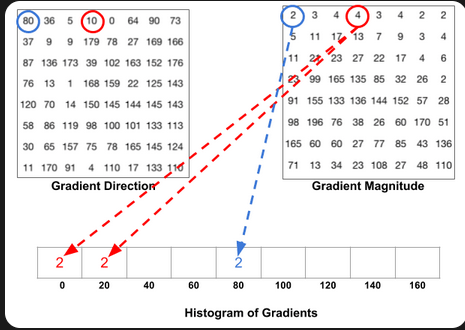
  - El caso especial (Wrapping): Si un ángulo es de 165∘, está cerca de 160∘ y de 180∘ (que es lo mismo que 0∘). Así que reparte su voto entre la cubeta de 160 y la de 0.
  - 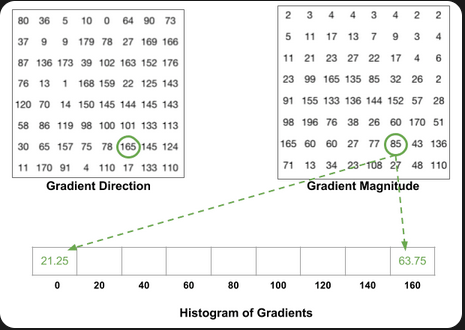
- En resumen: Tomamos cuadrículas de 8×8, miramos todas las flechas dentro, y creamos un pequeño gráfico de barras de 9 columnas que nos dice: "Aquí dominan las líneas horizontales" o "Aquí hay muchas diagonales".
- 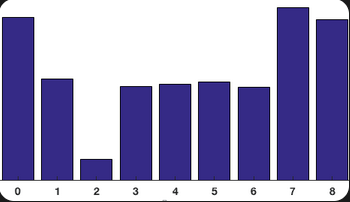

In [10]:
# Paso 3: Calcular histogramas de gradientes en celdas 8x8

# Parámetros
cell_size = 8  # Tamaño de la celda (8x8 píxeles)
bin_size = 20  # Tamaño de cada bin (180/9 = 20 grados)
nbins = 9      # Número de bins (0°, 20°, 40°, ..., 160°)

# Dimensiones de la imagen
height, width = mag.shape[:2]

# Calcular número de celdas
cell_rows = height // cell_size  # 128 / 8 = 16 celdas en vertical
cell_cols = width // cell_size   # 64 / 8 = 8 celdas en horizontal

print(f"Imagen: {width}x{height} píxeles")
print(f"Tamaño de celda: {cell_size}x{cell_size} píxeles")
print(f"Número de celdas: {cell_cols}x{cell_rows} = {cell_cols * cell_rows} celdas")
print(f"Cada celda tendrá un histograma de {nbins} bins\n")

# Crear matriz para almacenar los histogramas
# Dimensiones: (filas_celdas, columnas_celdas, nbins)
histogram = np.zeros((cell_rows, cell_cols, nbins))

# Iterar sobre cada celda
for i in range(cell_rows):
    for j in range(cell_cols):
        # Extraer la celda 8x8 actual
        y_start = i * cell_size
        y_end = (i + 1) * cell_size
        x_start = j * cell_size
        x_end = (j + 1) * cell_size
        
        # Magnitud y ángulo de la celda actual
        cell_mag = mag[y_start:y_end, x_start:x_end]
        cell_angle = angle[y_start:y_end, x_start:x_end]
        
        # Calcular histograma para esta celda
        # Convertir ángulos de 0-360 a 0-180 (unsigned gradients)
        cell_angle_unsigned = cell_angle % 180
        
        # Para cada píxel en la celda
        for y in range(cell_size):
            for x in range(cell_size):
                # Magnitud y ángulo del píxel
                magnitude = cell_mag[y, x, 0]
                angle_value = cell_angle_unsigned[y, x, 0]
                
                # Encontrar los dos bins más cercanos
                bin_index = angle_value / bin_size  # Ej: 45° / 20 = 2.25
                bin_left = int(np.floor(bin_index)) % nbins
                bin_right = (bin_left + 1) % nbins
                
                # Calcular el peso para cada bin (interpolación lineal)
                weight_right = (bin_index - bin_left)
                weight_left = 1.0 - weight_right
                
                # Votar en los dos bins con el peso de la magnitud
                histogram[i, j, bin_left] += magnitude * weight_left
                histogram[i, j, bin_right] += magnitude * weight_right

print(f"Histogramas calculados")
print(f"Forma de la matriz de histogramas: {histogram.shape}")
print(f"  - {histogram.shape[0]} filas de celdas")
print(f"  - {histogram.shape[1]} columnas de celdas")
print(f"  - {histogram.shape[2]} bins por histograma")

Imagen: 64x128 píxeles
Tamaño de celda: 8x8 píxeles
Número de celdas: 8x16 = 128 celdas
Cada celda tendrá un histograma de 9 bins

Histogramas calculados
Forma de la matriz de histogramas: (16, 8, 9)
  - 16 filas de celdas
  - 8 columnas de celdas
  - 9 bins por histograma


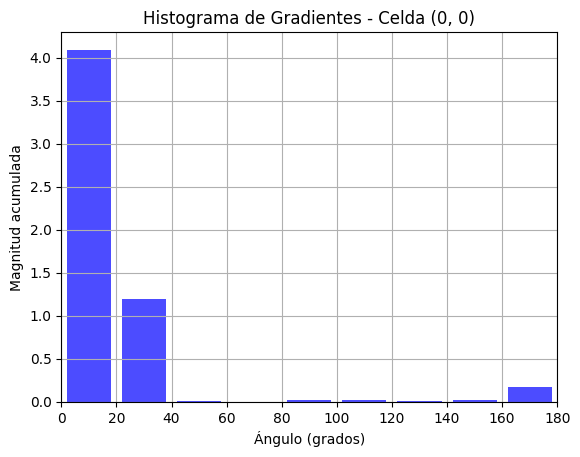

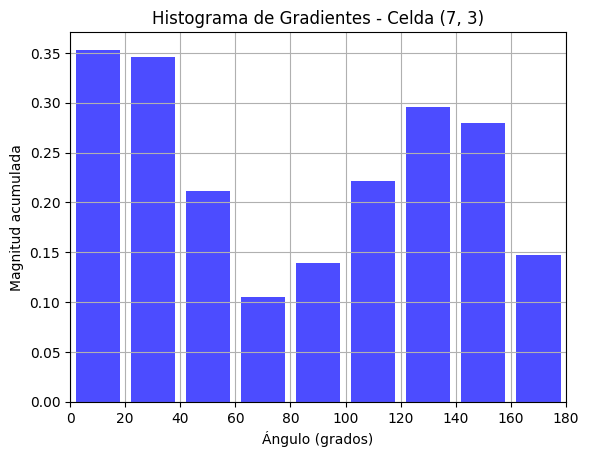

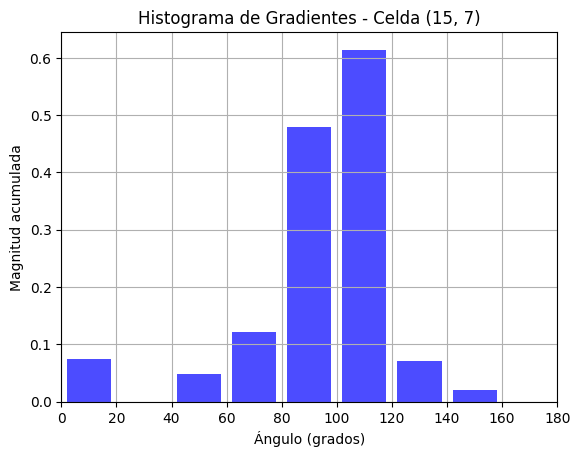

In [11]:
# Visualizar algunos histogramas de celdas
def plot_cell_histogram(cell_row, cell_col):
    """Función para graficar el histograma de una celda específica"""
    hist = histogram[cell_row, cell_col]
    bins = np.arange(nbins) * bin_size + bin_size / 2  # Centros de los bins
    
    plt.bar(bins, hist.flatten(), width=bin_size * 0.8, align='center', color='blue', alpha=0.7)
    plt.xlim(0, 180)
    plt.xlabel('Ángulo (grados)')
    plt.ylabel('Magnitud acumulada')
    plt.title(f'Histograma de Gradientes - Celda ({cell_row}, {cell_col})')
    plt.grid()
    plt.show()
# Graficar histogramas de algunas celdas
plot_cell_histogram(0, 0)  # Celda superior izquierda
plot_cell_histogram(7, 3)  # Celda central
plot_cell_histogram(15, 7) # Celda inferior derecha

### Paso 4: Normalización por Bloques (16×16)

1. El Problema: La Luz cambia los números

- Imagina que tomas una foto de un objeto al sol y otra en la sombra.
  - Aunque la forma es la misma, los números de los píxeles cambian (son más bajos en la sombra).
  - Esto haría que las magnitudes de tus gradientes se reduzcan a la mitad, cambiando tu histograma.
  - El objetivo: Queremos que el algoritmo reconozca el objeto sin importar si la foto está oscura o brillante.

2. La Solución Matemática: "Normalización"

- La normalización es un truco matemático para eliminar la "escala" (el brillo total).
  - Ejemplo del texto: Tienes un vector de color [128,64,32]. Su "longitud" total es 146.64. Si divides cada número por esa longitud, obtienes [0.87,0.43,0.22].
  - La magia: Si duplicas el brillo ([256,128,64]) y haces la misma operación, obtienes exactamente el mismo resultado: [0.87,0.43,0.22].
  - Así logramos que el brillo sea irrelevante.

3. La Estrategia HOG: Bloques de 16×16

- Podríamos normalizar cada celda de 8×8 por separado, pero HOG prefiere mirar un contexto un poco más grande para ser más preciso.
  - Agrupa 4 celdas de 8×8 para formar un bloque de 16×16.
  - Como cada celda tenía 9 valores (el histograma), ahora concatenamos (unimos) los 4 histogramas.
  - Resultado: Un vector largo de 36 números (4 celdas×9 valores).
  - Luego, aplicamos la normalización a esos 36 números juntos.
- 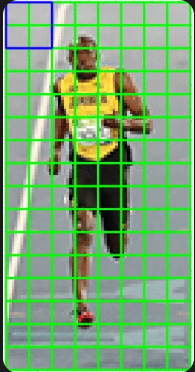

4. El "Deslizamiento" (Sliding Window)

- Aquí hay un detalle clave: estos bloques no son independientes como fichas de ajedrez. Se solapan.
  - La ventana de 16×16 se mueve de 8 en 8 píxeles.
  - Esto significa que cada celda se normaliza varias veces (como parte de diferentes bloques vecinos), lo que ayuda a conectar la información de una zona con la de al lado.

- En resumen: Agrupamos las celdas en bloques de 4, juntamos sus números (36 en total) y los "lavamos" matemáticamente para que la luz no afecte el resultado.

In [12]:
# Paso 4: Normalización por bloques 16x16

# Parámetros
block_size = 2  # Bloque de 2x2 celdas (equivale a 16x16 píxeles)
block_stride = 1  # Desplazamiento de 1 celda (8 píxeles)
epsilon = 1e-5  # Pequeño valor para evitar división por cero

# Calcular cuántos bloques caben
blocks_rows = cell_rows - block_size + 1  # 16 - 2 + 1 = 15 bloques en vertical
blocks_cols = cell_cols - block_size + 1  # 8 - 2 + 1 = 7 bloques en horizontal

print(f"Tamaño del bloque: {block_size}x{block_size} celdas ({block_size*cell_size}x{block_size*cell_size} píxeles)")
print(f"Número de bloques: {blocks_cols}x{blocks_rows} = {blocks_cols * blocks_rows} bloques")
print(f"Cada bloque tiene: {block_size * block_size * nbins} valores ({block_size}x{block_size} celdas × {nbins} bins)\n")

# Lista para almacenar todos los bloques normalizados
normalized_blocks = []

# Deslizar la ventana de bloques
for i in range(blocks_rows):
    for j in range(blocks_cols):
        # Extraer el bloque 2x2 de celdas
        block = histogram[i:i+block_size, j:j+block_size, :]
        
        # Aplanar el bloque en un vector de 36 valores (2×2×9)
        block_vector = block.flatten()
        
        # Normalización L2-norm (más común en HOG)
        # norm = sqrt(v1² + v2² + ... + v36² + ε)
        norm = np.sqrt(np.sum(block_vector ** 2) + epsilon)
        
        # Dividir cada valor por la norma
        normalized_block = block_vector / norm
        
        # Guardar el bloque normalizado
        normalized_blocks.append(normalized_block)

# Convertir a array numpy
hog_features = np.array(normalized_blocks).flatten()

print(f"Bloques normalizados")
print(f"Número total de bloques: {len(normalized_blocks)}")
print(f"Dimensión del vector HOG final: {len(hog_features)}")
print(f"  - {blocks_rows * blocks_cols} bloques × {block_size * block_size * nbins} valores = {len(hog_features)} características")
print(f"\nVector de características HOG completo generado!")
print(f"  Este vector de {len(hog_features)} números representa la imagen de Usain Bolt")

Tamaño del bloque: 2x2 celdas (16x16 píxeles)
Número de bloques: 7x15 = 105 bloques
Cada bloque tiene: 36 valores (2x2 celdas × 9 bins)

Bloques normalizados
Número total de bloques: 105
Dimensión del vector HOG final: 3780
  - 105 bloques × 36 valores = 3780 características

Vector de características HOG completo generado!
  Este vector de 3780 números representa la imagen de Usain Bolt


### Paso 5: Calcular el Vector de Características Final.

- Ahora toca empaquetar todo lo que hemos calculado en los pasos anteriores para entregárselo al clasificador (SVM).

1. El Ensamblaje (¿Cuántos bloques caben?)

- Recuerda que estamos moviendo una ventana de "Bloque" (16×16) sobre nuestra imagen de 64×128, dando pasos de 8 píxeles (stride). Hay que calcular cuántas veces encaja esa ventana:
  - A lo ancho (Horizontal): En los 64 píxeles de ancho, moviéndose de 8 en 8, el bloque cabe en 7 posiciones distintas.
  - A lo alto (Vertical): En los 128 píxeles de alto, cabe en 15 posiciones distintas.
  - Total de bloques: 7 horizontal×15 vertical=105 bloques en total.

2. El Número Mágico: 3780

- Esta es la cifra que mencionamos al puro principio y ahora ya sabes de dónde sale.
  - Tenemos 105 bloques.
  - Cada bloque nos da un vector de 36 números (recuerda: 4 celdas × 9 ángulos).
  - La cuenta final:
    - 105 bloques×36 valores=3780 valores
- Este vector gigante de 3780 números es la "huella digital" final de la imagen. Es lo que el algoritmo de SVM recibe para decir: "Sí, esto es una persona" o "No, esto es una farola".

3. La Visualización (Ver lo invisible)

- 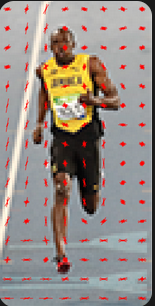

- La imagen muestra cómo se ve esto representado gráficamente.
  - En lugar de dibujar píxeles, se dibujan las "estrellas" o líneas de gradiente dominantes en cada celda.
  - Observa: Puedes ver claramente la silueta del corredor, especialmente alrededor del torso y las piernas. El algoritmo ha ignorado el color de la pista y la ropa, quedándose solo con la estructura de la forma humana.

Imagen cargada correctamente. Tipo de dato: uint8
Generando visualización...


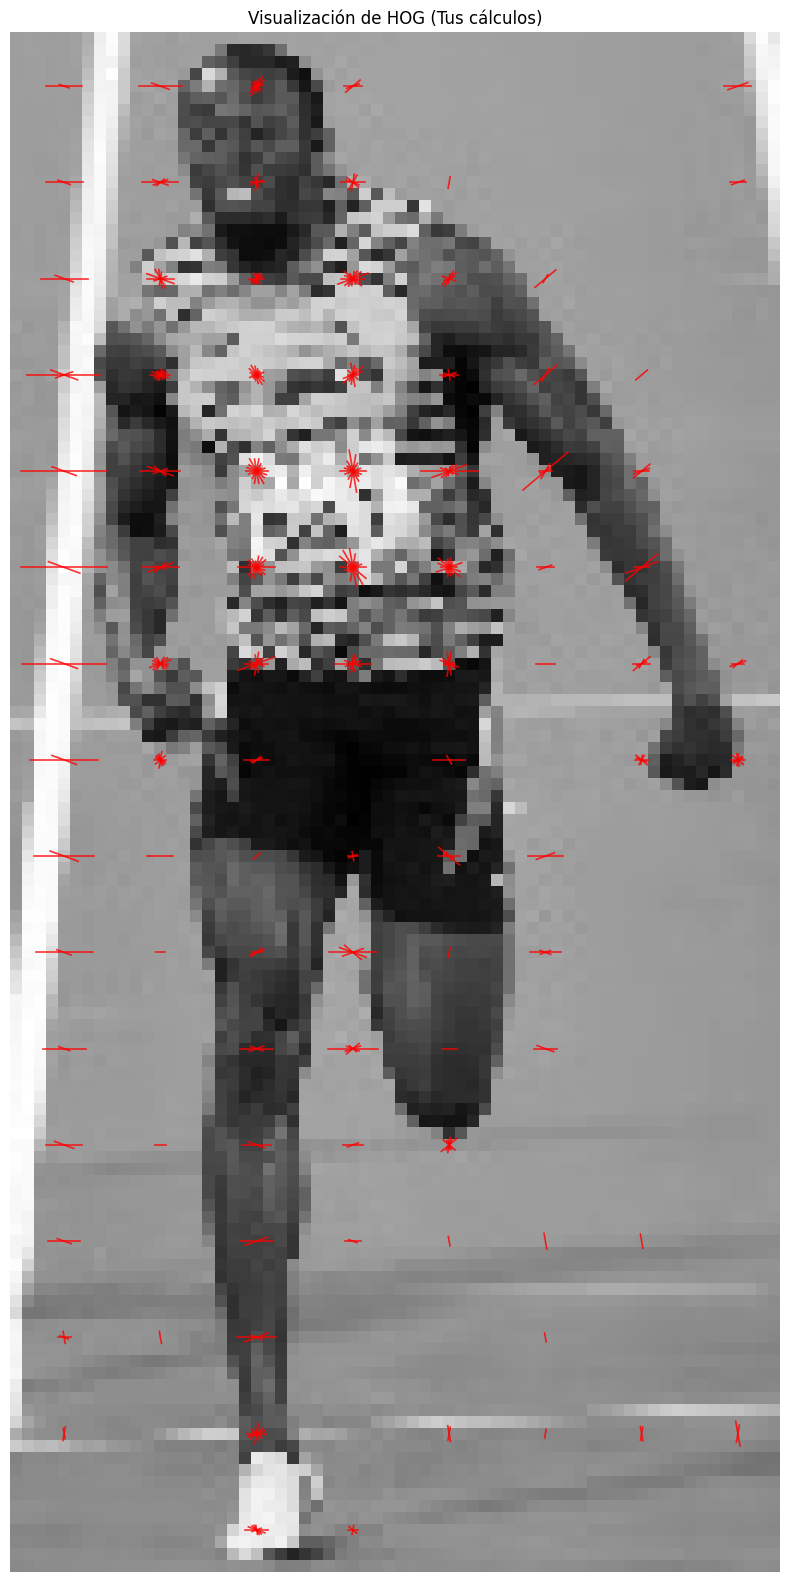

In [19]:
def visualizar_hog(imagen, histograma, cell_size=8, bin_size=20):
    """
    Dibuja la visualización de HOG basada en los histogramas calculados manualmente.
    """
    plt.figure(figsize=(10, 20))
    plt.imshow(imagen, cmap='gray')
    
    filas_celdas, cols_celdas, nbins = histograma.shape
    
    # Encontramos el valor máximo para escalar el tamaño de las líneas
    max_mag = np.max(histograma)
    
    # Recorrer cada celda de la imagen (16x8)
    for i in range(filas_celdas):
        for j in range(cols_celdas):
            # Calcular el centro (x, y) de la celda actual en píxeles
            cx = j * cell_size + cell_size / 2
            cy = i * cell_size + cell_size / 2
            
            # Tomar el histograma de 9 bins de esta celda
            hist_celda = histograma[i, j]
            
            # Por cada uno de los 9 ángulos (bins)
            for bin_idx in range(nbins):
                magnitud = hist_celda[bin_idx]
                
                # Si la magnitud es muy pequeña (ruido), no la dibujamos para que se vea limpio.
                if magnitud < 0.1 * max_mag:
                    continue
                
                # Calcular el ángulo real en radianes
                angulo_grados = bin_idx * bin_size
                # Dibujamos la dirección del gradiente. 
                # Un borde vertical tendrá gradientes horizontales, verás líneas horizontales
                angulo_rad = angulo_grados * np.pi / 180
                
                # Calcular longitud de la línea (proporcional a la fuerza del gradiente)
                longitud = (magnitud / max_mag) * cell_size * 0.9
                
                # Calcular coordenadas (dx, dy) usando trigonometría básica
                dx = np.cos(angulo_rad) * longitud / 2
                dy = np.sin(angulo_rad) * longitud / 2
                
                # Dibujar la línea centrada en la celda
                plt.plot([cx - dx, cx + dx], [cy - dy, cy + dy], 
                         color='red', linewidth=1.2, alpha=0.8)
    
    plt.title("Visualización de HOG (Tus cálculos)")
    plt.axis('off') # Ocultar ejes para que parezca una foto
    plt.show()

img_visualizacion = cv2.imread('usain_bolt_hog_64x128.jpg')

if img_visualizacion is None:
    print("No se encontró la imagen.")
else:
    # Convertir a escala de grises para el fondo
    img_visualizacion = cv2.cvtColor(img_visualizacion, cv2.COLOR_BGR2GRAY)
    print(f"Imagen cargada correctamente. Tipo de dato: {img_visualizacion.dtype}")
    visualizar_hog(img_visualizacion, histogram)


### Resumen Final del Tutorial (Top-Down)

- Preprocesamiento: Recortar a 64×128.
- Gradientes: Detectar bordes y descartar colores planos.
- Histogramas (8×8): Resumir los bordes en 9 direcciones principales.
- Normalización (16×16): Ajustar el brillo agrupando celdas.
- Vector Final: Concatenar todo en una lista de 3780 números.

### Código completo

Imagen cargada correctamente. Tipo de dato: uint8
Generando visualización...


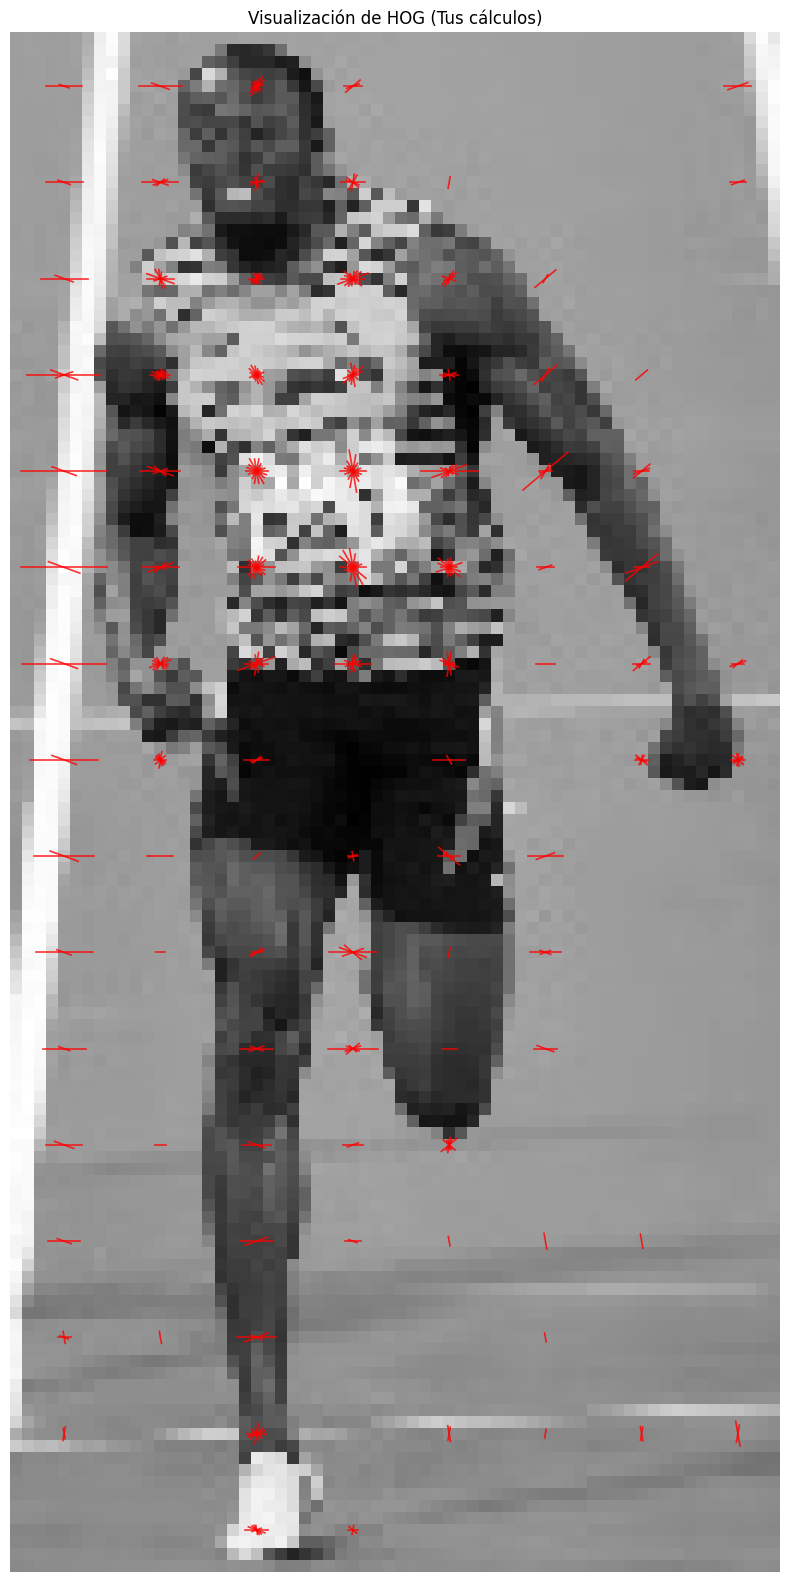

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

%matplotlib inline


# Paso 2: Calcular gradientes usando la imagen redimensionada

im = cv2.imread('usain_bolt_hog_64x128.jpg')
im = np.float32(im) / 255.0
# Calculate gradient
gx = cv2.Sobel(im, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(im, cv2.CV_32F, 0, 1, ksize=1)
# Python Calculate gradient magnitude and direction ( in degrees )
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

# Paso 3: Calcular histogramas de gradientes en celdas 8x8

# Parámetros
cell_size = 8  # Tamaño de la celda (8x8 píxeles)
bin_size = 20  # Tamaño de cada bin (180/9 = 20 grados)
nbins = 9      # Número de bins (0°, 20°, 40°, ..., 160°)

# Dimensiones de la imagen
height, width = mag.shape[:2]

# Calcular número de celdas
cell_rows = height // cell_size  # 128 / 8 = 16 celdas en vertical
cell_cols = width // cell_size   # 64 / 8 = 8 celdas en horizontal

# Crear matriz para almacenar los histogramas
histogram = np.zeros((cell_rows, cell_cols, nbins))

# Iterar sobre cada celda
for i in range(cell_rows):
    for j in range(cell_cols):
        # Extraer la celda 8x8 actual
        y_start = i * cell_size
        y_end = (i + 1) * cell_size
        x_start = j * cell_size
        x_end = (j + 1) * cell_size
        
        # Magnitud y ángulo de la celda actual
        cell_mag = mag[y_start:y_end, x_start:x_end]
        cell_angle = angle[y_start:y_end, x_start:x_end]
        
        # Calcular histograma para esta celda
        # Convertir ángulos de 0-360 a 0-180 (unsigned gradients)
        cell_angle_unsigned = cell_angle % 180
        
        # Para cada píxel en la celda
        for y in range(cell_size):
            for x in range(cell_size):
                # Magnitud y ángulo del píxel
                magnitude = cell_mag[y, x, 0]
                angle_value = cell_angle_unsigned[y, x, 0]
                
                # Encontrar los dos bins más cercanos
                bin_index = angle_value / bin_size  # Ej: 45° / 20 = 2.25
                bin_left = int(np.floor(bin_index)) % nbins
                bin_right = (bin_left + 1) % nbins
                
                # Calcular el peso para cada bin (interpolación lineal)
                weight_right = (bin_index - bin_left)
                weight_left = 1.0 - weight_right
                
                # Votar en los dos bins con el peso de la magnitud
                histogram[i, j, bin_left] += magnitude * weight_left
                histogram[i, j, bin_right] += magnitude * weight_right

# Paso 4: Normalización por bloques 16x16

# Parámetros
block_size = 2  # Bloque de 2x2 celdas (equivale a 16x16 píxeles)
block_stride = 1  # Desplazamiento de 1 celda (8 píxeles)
epsilon = 1e-5  # Pequeño valor para evitar división por cero

# Calcular cuántos bloques caben
blocks_rows = cell_rows - block_size + 1  # 16 - 2 + 1 = 15 bloques en vertical
blocks_cols = cell_cols - block_size + 1  # 8 - 2 + 1 = 7 bloques en horizontal

# Lista para almacenar todos los bloques normalizados
normalized_blocks = []

# Deslizar la ventana de bloques
for i in range(blocks_rows):
    for j in range(blocks_cols):
        # Extraer el bloque 2x2 de celdas
        block = histogram[i:i+block_size, j:j+block_size, :]
        
        # Aplanar el bloque en un vector de 36 valores (2×2×9)
        block_vector = block.flatten()
        
        # Normalización L2-norm (más común en HOG)
        # norm = sqrt(v1² + v2² + ... + v36² + ε)
        norm = np.sqrt(np.sum(block_vector ** 2) + epsilon)
        
        # Dividir cada valor por la norma
        normalized_block = block_vector / norm
        
        # Guardar el bloque normalizado
        normalized_blocks.append(normalized_block)

# Convertir a array numpy
hog_features = np.array(normalized_blocks).flatten()

# Paso 5: Visualización de HOG

def visualizar_hog(imagen, histograma, cell_size=8, bin_size=20):
    """
    Dibuja la visualización de HOG basada en los histogramas calculados manualmente.
    """
    plt.figure(figsize=(10, 20))
    plt.imshow(imagen, cmap='gray')
    
    filas_celdas, cols_celdas, nbins = histograma.shape
    
    # Encontramos el valor máximo para escalar el tamaño de las líneas
    # (Para que la línea más larga quepa dentro de su celda)
    max_mag = np.max(histograma)
    
    print("Generando visualización...")
    
    # Recorrer cada celda de la imagen (16x8)
    for i in range(filas_celdas):
        for j in range(cols_celdas):
            # Calcular el centro (x, y) de la celda actual en píxeles
            cx = j * cell_size + cell_size / 2
            cy = i * cell_size + cell_size / 2
            
            # Tomar el histograma de 9 bins de esta celda
            hist_celda = histograma[i, j]
            
            # Por cada uno de los 9 ángulos (bins)
            for bin_idx in range(nbins):
                magnitud = hist_celda[bin_idx]
                
                # Si la magnitud es muy pequeña (ruido), no la dibujamos para que se vea limpio.
                if magnitud < 0.1 * max_mag:
                    continue
                
                # Calcular el ángulo real en radianes
                angulo_grados = bin_idx * bin_size
                # Dibujamos la dirección del gradiente. 
                # Un borde vertical tendrá gradientes horizontales, verás líneas horizontales
                angulo_rad = angulo_grados * np.pi / 180
                
                # Calcular longitud de la línea (proporcional a la fuerza del gradiente)
                longitud = (magnitud / max_mag) * cell_size * 0.9
                
                # Calcular coordenadas (dx, dy) usando trigonometría básica
                dx = np.cos(angulo_rad) * longitud / 2
                dy = np.sin(angulo_rad) * longitud / 2
                
                # Dibujar la línea centrada en la celda
                plt.plot([cx - dx, cx + dx], [cy - dy, cy + dy], 
                         color='red', linewidth=1.2, alpha=0.8)
    
    plt.title("Visualización de HOG (Tus cálculos)")
    plt.axis('off') # Ocultar ejes para que parezca una foto
    plt.show()

img_visualizacion = cv2.imread('usain_bolt_hog_64x128.jpg')

if img_visualizacion is None:
    print("No se encontró la imagen.")
else:
    # Convertir a escala de grises para el fondo
    img_visualizacion = cv2.cvtColor(img_visualizacion, cv2.COLOR_BGR2GRAY)
    
    print(f"Imagen cargada correctamente. Tipo de dato: {img_visualizacion.dtype}")
    
    visualizar_hog(img_visualizacion, histogram)
